<a href="https://www.kaggle.com/code/goktani/yolov11-liquid-level-detection?scriptVersionId=292905064" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧪 Proof of Concept: Liquid Level Estimation via Object Detection

## Project Overview
This notebook demonstrates an experimental approach to estimate the liquid fill level in containers using Computer Vision. Unlike standard classification, this project combines **Object Detection (YOLOv11)** with **Geometric Logic**.

**The Methodology:**
1.  **Detect:** Identify `Container` and `Fluid` objects using a fine-tuned YOLO model.
2.  **Map:** Determine which fluid belongs to which container based on coordinate overlapping.
3.  **Calculate:** Use pixel-height ratios to estimate the fill percentage `(Fluid Height / Container Height)`.

## Dataset & Acknowledgements
This project utilizes the **SAM2 Liquid Sem Segmentation** dataset hosted on Roboflow.
* **Source:** [Roboflow Universe - SAM2 Liquid Sem Segmentation](https://universe.roboflow.com/liquids/sam2-liquid-sem-segmentation)
* **Note:** This is a Proof of Concept (POC). The dataset is used here for experimental purposes to test the logic script.

## Technical Stack
* **Ultralytics YOLOv11:** For object detection.
* **OpenCV & NumPy:** For post-processing and geometric calculations.
* **Pandas & XlsxWriter:** For automated reporting with embedded visuals.

**Setup & Installation**

In [1]:
# Install necessary libraries
# We need roboflow for dataset retrieval and xlsxwriter for the final report
!pip install roboflow ultralytics xlsxwriter -q

import os
import torch

# Define main output directory for Kaggle
# Kaggle allows writing files only to /kaggle/working/
OUTPUT_DIR = "/kaggle/working/Liquid_Level_Project"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✅ Environment Setup Complete.")
print(f"📂 Working Directory: {OUTPUT_DIR}")
print(f"🖥️ GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is in

**Download Dataset**

In [2]:
from roboflow import Roboflow
from kaggle_secrets import UserSecretsClient # Kaggle'ın güvenlik kütüphanesi
import yaml

# 1. Retrieve API Key securely from Kaggle Secrets
user_secrets = UserSecretsClient()
# Eğer Secret adını farklı koyduysan parantez içini değiştir
secret_value_0 = user_secrets.get_secret("ROBOFLOW_KEY") 

# 2. Initialize Roboflow
rf = Roboflow(api_key=secret_value_0)
project = rf.workspace("tan-b1re6").project("sam2-liquid-sem-segmentation-bpmm3")
version = project.version(1)

# 3. Download Dataset
dataset = version.download("yolov11", location="/kaggle/working/dataset")

print(f"✅ Dataset successfully downloaded using secure key.")

# 4. Check Class Names
with open(f"{dataset.location}/data.yaml", 'r') as stream:
    data_yaml = yaml.safe_load(stream)
    print("\n🧐 DATASET CLASSES:")
    print(data_yaml['names'])

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /kaggle/working/dataset in yolov11:: 100%|██████████| 684/684 [00:00<00:00, 10024.09it/s]

✅ Dataset successfully downloaded using secure key.

🧐 DATASET CLASSES:
['container', 'fluid', 'fluid-surface']


**Training YOLOv11**

In [3]:
from ultralytics import YOLO

# Load a pre-trained YOLOv11 nano model (lightweight and fast)
model = YOLO('yolo11n.pt')

# Start Training
# We set 'project' to our output directory so we can find weights easily
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,          # Adjust based on time limits
    imgsz=640,
    batch=16,
    plots=True,
    project=f"{OUTPUT_DIR}/training_runs",
    name='exp1',        # Experiment name
    exist_ok=True
)

print(f"✅ Training completed.")
print(f"⚖️ Best weights saved at: {OUTPUT_DIR}/training_runs/exp1/weights/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou

**Inference & Geometric Logic (The Core)**

In [4]:
import cv2
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BEST_WEIGHTS = f"{OUTPUT_DIR}/training_runs/exp1/weights/best.pt"
TEST_IMAGES_DIR = f"{dataset.location}/test/images"
RESULTS_DIR = f"{OUTPUT_DIR}/analyzed_images"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Class IDs (Based on Roboflow dataset configuration)
# Usually: 0 -> Container, 1 -> Fluid (Verify this in your data.yaml)
CLASS_CONTAINER = 0
CLASS_FLUID = 1

# Load the trained model
print("Loading trained model...")
model = YOLO(BEST_WEIGHTS)

# List to store analysis data for the report
data_log = []

# Get test images
image_files = glob.glob(f"{TEST_IMAGES_DIR}/*.jpg")
print(f"🔍 Found {len(image_files)} test images. Starting logic analysis...")

for img_file in image_files:
    filename = os.path.basename(img_file)
    
    # Read image with OpenCV
    img = cv2.imread(img_file)
    if img is None: continue
    
    h_img, w_img, _ = img.shape

    # Run Inference
    results = model.predict(img, conf=0.25, verbose=False)[0]

    # Separate detections into Containers and Fluids
    containers = []
    fluids = []

    for box in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls_id = box
        if int(cls_id) == CLASS_CONTAINER:
            containers.append({'box': [x1, y1, x2, y2], 'conf': conf})
        elif int(cls_id) == CLASS_FLUID:
            fluids.append({'box': [x1, y1, x2, y2], 'conf': conf})

    # --- GEOMETRIC LOGIC ---
    # We iterate through each container to see if it contains a fluid
    for c_idx, cont in enumerate(containers):
        cx1, cy1, cx2, cy2 = cont['box']

        # Draw Container (Blue Box)
        cv2.rectangle(img, (int(cx1), int(cy1)), (int(cx2), int(cy2)), (255, 0, 0), 2)

        matched_fluid = None
        
        # Check overlap: Is the center of a fluid inside this container?
        for fluid in fluids:
            fx1, fy1, fx2, fy2 = fluid['box']
            f_center_x = (fx1 + fx2) / 2
            f_center_y = (fy1 + fy2) / 2

            if cx1 < f_center_x < cx2 and cy1 < f_center_y < cy2:
                matched_fluid = fluid
                break # Assume one fluid per container for this POC

        fill_percentage = 0.0
        label_color = (0, 0, 255) # Red (Empty/Error)
        status_text = "Empty"

        if matched_fluid:
            fx1, fy1, fx2, fy2 = matched_fluid['box']

            # Draw Fluid (Green Box)
            cv2.rectangle(img, (int(fx1), int(fy1)), (int(fx2), int(fy2)), (0, 255, 0), 2)

            # Calculate Heights
            container_height = cy2 - cy1
            # Fluid level is determined from the bottom of the container to the top of the fluid
            filled_height = cy2 - fy1 

            if container_height > 0:
                # Calculate Ratio
                ratio = (filled_height / container_height) * 100
                fill_percentage = min(max(ratio, 0), 100) # Clamp between 0-100
                label_color = (0, 255, 0) # Green (Success)
                status_text = f"{fill_percentage:.1f}%"

        # Display Text on Image
        label = f"Lvl: {status_text}"
        cv2.putText(img, label, (int(cx1), int(cy1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, label_color, 2)

        # Log Data
        data_log.append({
            "File": filename,
            "Container_ID": c_idx + 1,
            "Fill_Percentage": round(fill_percentage, 2),
            "Status": "Detected" if matched_fluid else "Empty"
        })

    # Save processed image
    save_path = os.path.join(RESULTS_DIR, filename)
    cv2.imwrite(save_path, img)

# Save raw data to simple Excel first
df = pd.DataFrame(data_log)
raw_excel_path = f"{OUTPUT_DIR}/raw_data.xlsx"
df.to_excel(raw_excel_path, index=False)

print(f"✅ Analysis Complete.")
print(f"📄 Processed {len(image_files)} images.")

Loading trained model...
🔍 Found 15 test images. Starting logic analysis...
✅ Analysis Complete.
📄 Processed 15 images.


**Generating Visual Report**

In [5]:
import pandas as pd

# Define paths
input_excel = raw_excel_path
final_report_path = f"{OUTPUT_DIR}/Final_Liquid_Level_Report.xlsx"
images_source_dir = RESULTS_DIR

# Check if data exists
if os.path.exists(input_excel):
    df = pd.read_excel(input_excel)
    print(f"📊 Generating rich report for {len(df)} entries...")

    # Create Excel Writer with XlsxWriter engine
    with pd.ExcelWriter(final_report_path, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name='Analysis_Report', index=False)

        workbook = writer.book
        worksheet = writer.sheets['Analysis_Report']

        # Formats
        header_fmt = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#4F81BD', 'font_color': 'white', 'border': 1})
        center_fmt = workbook.add_format({'align': 'center', 'valign': 'vcenter'})
        
        # Apply Header Format
        for col_num, value in enumerate(df.columns.values):
            worksheet.write(0, col_num, value, header_fmt)

        # Add "Visual" Column Header
        img_col_idx = len(df.columns)
        worksheet.write(0, img_col_idx, "Visual_Reference", header_fmt)

        # Set Column Widths
        worksheet.set_column(0, img_col_idx - 1, 15, center_fmt)
        worksheet.set_column(img_col_idx, img_col_idx, 30) # Wider for images

        # Insert Images
        for i, row in df.iterrows():
            # Set row height to accommodate image
            worksheet.set_row(i + 1, 100)
            
            img_filename = row['File']
            img_path = os.path.join(images_source_dir, img_filename)

            if os.path.exists(img_path):
                worksheet.insert_image(i + 1, img_col_idx, img_path, {
                    'x_scale': 0.15, 
                    'y_scale': 0.15,
                    'object_position': 1,
                    'x_offset': 5, 'y_offset': 5
                })
            else:
                worksheet.write(i + 1, img_col_idx, "Image Not Found")

    print(f"✅ Report saved successfully: {final_report_path}")
else:
    print("⚠️ No input data found. Did the previous step run correctly?")

📊 Generating rich report for 36 entries...
✅ Report saved successfully: /kaggle/working/Liquid_Level_Project/Final_Liquid_Level_Report.xlsx


**Visualizing Results in Notebook**

👀 Preview of Analyzed Images:


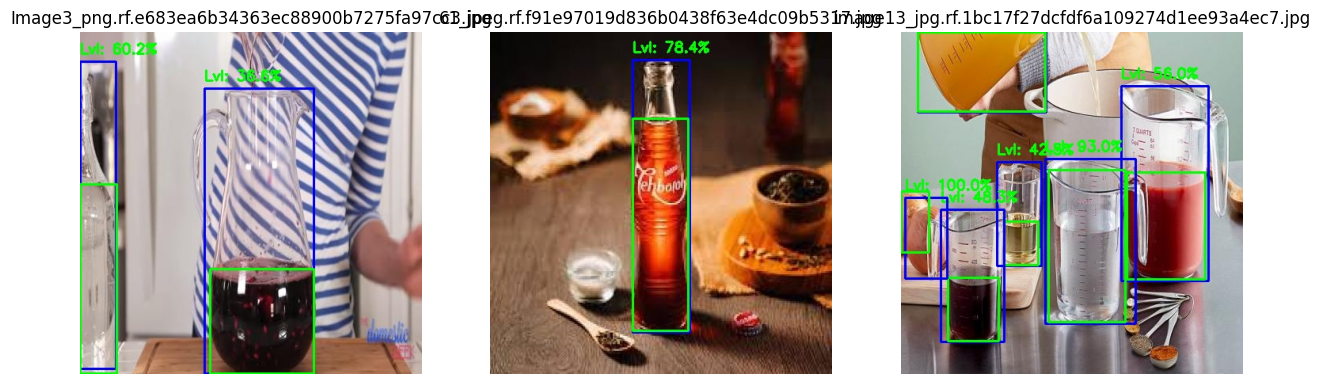

In [6]:
# Display a few random results directly in the notebook
import random
from PIL import Image

output_images = glob.glob(f"{RESULTS_DIR}/*.jpg")

if output_images:
    print("👀 Preview of Analyzed Images:")
    # Pick 3 random images
    sample_images = random.sample(output_images, min(3, len(output_images)))
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()
else:
    print("No images to display.")